# DBSCAN

The DBSCAN algorithm takes a different approach. Rather than having to provide the number of clusters, $k$, you define parameters related to neighborhoods and target density.

**Neighborhoods** 

Consider any point $p$. The $\epsilon$-neighborhood of $p$ is the set of all points within a distance of $\epsilon$  from $p$ . That is, if $\{\hat{X}_0,\hat{X}_1,\ldots,\hat{X}_{m-1}\}$ is a collection of $m$ data points, then the  {\epsilon}-neighborhood centered at $p$ is $N_{\epsilon}(p) = \{\hat{x}_i : || \hat{X} - p ||_2 \le \epsilon$,
where the measure of distance is Euclidean (i.e., the two-norm). Notice that this definition would include the point $p$ if $p$ is one of the data points.

**Density**

The next important concept in DBSCAN is that of the density of a neighborhood. Intuitively, the DBSCAN algorithm will try to "grow" clusters around points whose neighborhoods are sufficiently dense.

Let's make this idea more precise.

**Definition: core points.** A point $p$ is a core point if its  $\epsilon$-neighborhood has at least $s$ points.
In other words, the algorithm now has two user-defined parameters: the neighborhood size, $\epsilon$ , and the minimum density, specified using a threshold $s$ on the number of points in such a neighborhood.

### Growing clusters via "reachable" points

The last concept needed for DBSCAN is the idea of growing a cluster around a core point. It depends on the notion of reachability.

**Definition: Reachability.** A point $q$ is reachable from another point$p$ if there exists a sequence of points $p=p_1,p_2,\ldots,p_k=q$ such that every $p_i$ is a core point, possibly except for $p_k=q$, and
$p_i \in N_{\epsilon}(p_{i-1})$ for all $1 < i < k$.

The procedure works as follows.

**"Expand Cluster"** procedure:
1. Consider any point $p$ that is not yet assigned to a cluster.
2. If  $p$ is a core point, then start a new cluster for it.
3. Maintain a "reachable" set, which will be used to hold points that are reachable from  $p$  as they are encountered. Initially, the reachable points are just  $p$'s  $\epsilon$-neighbors.
4. Remove any point  $q$  from the reachable set.
5. If  $q$  has not yet been visited, then mark it as being visited.
6. If  $q$  is also a core point, then add all of its neighbors to the reachable set, per the definition of "reachability" above.
7. If  $q$  is not yet assigned to any cluster, then add it to  $p$'s cluster.

Notice how this procedure explores the points reachable from  $p$  (Step 6). Intuitively, it is trying to join all neighborhoods whose core points are mutually contained.

![alt text](dbscan.png "Building the cluster in DBSCAN.")

In this figure, suppose the minimum density parameter is $s=3$ points. Thus, only the  $\epsilon$-neighborhoods centered at 1, 3, and 6 are core points, since these are the only points that include at least $s=3$ points. For instance, $N_{\epsilon}(1)=\{0,1,3,7\}$, making it a core point since its neighborhood has four (4) points, whereas  $N_{\epsilon}(4)=\{3,4\}$ is not a core point since its neighborhood has just two (2) points.


In [1]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors

from kneed import KneeLocator

ModuleNotFoundError: No module named 'kneed'

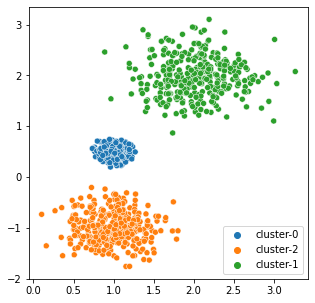

In [2]:
centers = [[1, 0.5], [2, 2], [1, -1]]
stds = [0.1, 0.4, 0.3]
X, labels_true = make_blobs(n_samples=1000, centers=centers, cluster_std=stds, random_state=0)

fig = plt.figure(figsize=(5, 5))
sns.scatterplot(X[:,0], X[:,1], hue=["cluster-{}".format(x) for x in labels_true])
plt.savefig("blobs.png", dpi=300)

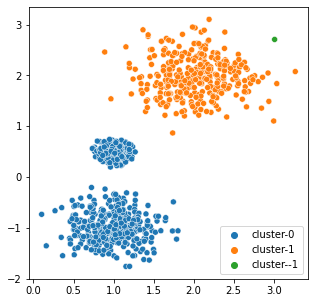

In [3]:
db = DBSCAN(eps=0.5, min_samples=10).fit(X)
labels = db.labels_

fig = plt.figure(figsize=(5, 5))
sns.scatterplot(X[:,0], X[:,1], hue=["cluster-{}".format(x) for x in labels])
plt.savefig("dbscan_dumb.png", dpi=300)

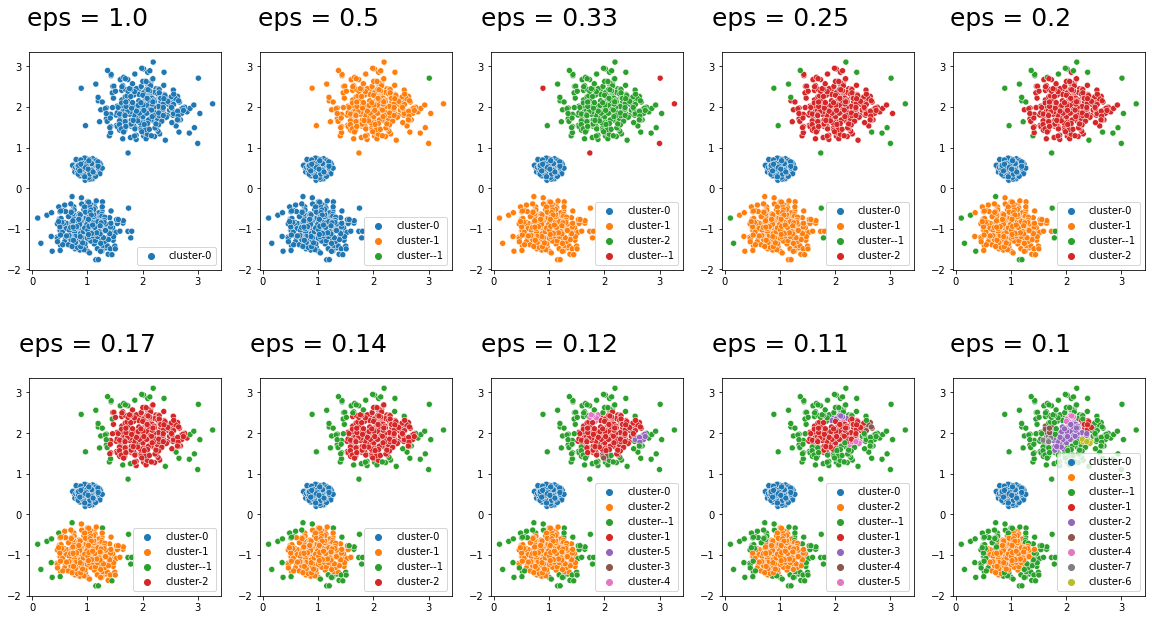

In [4]:
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=.5, wspace=.2)
i = 1

for x in range(10, 0, -1):
    eps = 1/(11-x)
    db = DBSCAN(eps=eps, min_samples=10).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    ax = fig.add_subplot(2, 5, i)
    ax.text(1, 4, "eps = {}".format(round(eps, 2)), fontsize=25, ha="center")
    sns.scatterplot(X[:,0], X[:,1], hue=["cluster-{}".format(x) for x in labels])
    
    i += 1
    
plt.savefig("multi_eps.png", dpi=300)

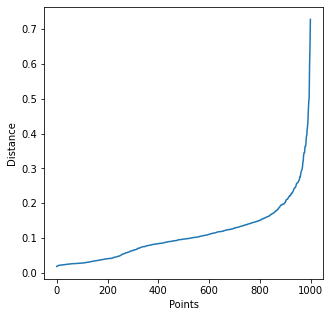

In [5]:
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)

distances = np.sort(distances[:,10], axis=0)
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

plt.savefig("Distance_curve.png", dpi=300)

0.18723454491446345


<Figure size 360x360 with 0 Axes>

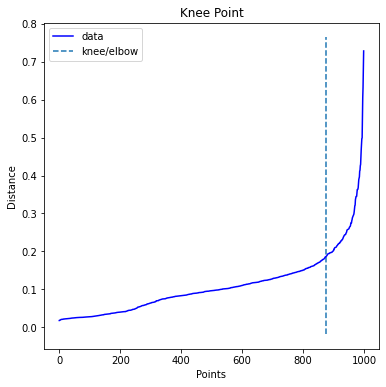

In [6]:
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.savefig("knee.png", dpi=300)
print(distances[knee.knee])

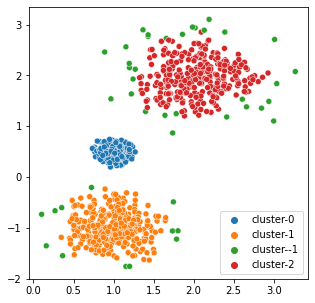

In [7]:
db = DBSCAN(eps=distances[knee.knee], min_samples=10).fit(X)
labels = db.labels_

fig = plt.figure(figsize=(5, 5))
sns.scatterplot(X[:,0], X[:,1], hue=["cluster-{}".format(x) for x in labels])
plt.savefig("dbscan_with_knee.png", dpi=300)

Automatically created module for IPython interactive environment
Estimated number of clusters: 3
Estimated number of noise points: 18
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.916
Silhouette Coefficient: 0.626


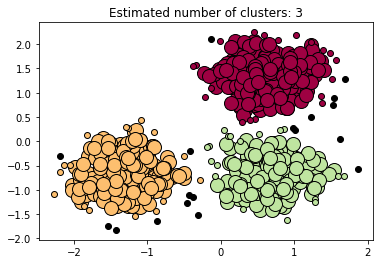

In [8]:
print(__doc__)

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Assignment 1 Stuff


| Min. | 1st Qu. |  Median  |  Mean | 3rd Qu. |  Max. |
|------|---------|----------|-------|---------|-------|
|0.00 | 22.50   | 27.00    | 24.87 | 30.00 |   30.00 |


There were 59 submissions that had a perfect score (30). As you can see above more than 25% of the submission are in the 3rd quartile, which is a 30.

We will try to release the solution as soon as we can. We are trying to make sure all of the Special Consideration Cases are resoled first.


# Assignment 2 Stuff

## Underfitting and Overfitting
Splitting a dataset is important for detecting if your model suffers from one of two very common problems, called underfitting and overfitting:

**Underfitting** is usually the consequence of a model being unable to capture the relationships in a dataset. For example, this can happen when trying to represent nonlinear relations with a linear model. Underfitted models will likely have poor performance with both training and test sets.

**Overfitting** usually takes place when a model has an overly complex structure and learns both the existing relationships in a dataset and the noise. Such models often have poor generalization capabilities. Although they work well on the training data, they usually yield poor performance with unseen (test) data.

In your assignment. These are the types of things you want to avoid. You do this by using a grid search to select the best parameters and cross-fold validation, i.e. you need to split your test data up using sklearn to do self validation within the folds.

In [1]:
import pandas as pd
import numpy as np


In [7]:
def strip_header(the_file):
  with open(the_file, 'r') as f:
    for line in f:
        if line.startswith('#'):
            header = line
        else:
            break #stop when there are no more #
  the_header = header[1:].strip().split(',')
  df = pd.read_csv(the_file,comment='#',names=the_header,sep=',')
  return df

dataset = strip_header('wineQualityReds.csv')

X = dataset.drop(['quality'],axis=1)
y = dataset['quality']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

from sklearn.preprocessing import StandardScaler
feature_scaler = StandardScaler()
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

In [8]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=300, random_state=0)

In [9]:
from sklearn.model_selection import cross_val_score
all_accuracy = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=5)

In [10]:
X.head()

fixed.acidity  volatile.acidity  citric.acid  residual.sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free.sulfur.dioxide  total.sulfur.dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  
0      9.4  
1      9.8  
2      9.8  
3      9.8  
4      9.4

In [11]:
y.head()

0    5
1    5
2    5
3    6
4    5
Name: quality, dtype: int64

In [22]:
print(all_accuracy)
print(all_accuracy.mean())

[0.64930556 0.64930556 0.63194444 0.67013889 0.67944251]
0.6560273906310492


In [14]:
from sklearn.model_selection import GridSearchCV
grid_param = {
        'n_estimators': [100, 300, 500, 800, 1000],
        'criterion': ['gini', 'entropy'],
        'bootstrap': [True, False]
}

gd_sr = GridSearchCV(estimator=classifier,
                         param_grid=grid_param,
                         scoring='accuracy',
                         cv=5,
                         n_jobs=-1)

gd_sr.fit(X_train, y_train)

best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_
print(best_result)

{'bootstrap': False, 'criterion': 'entropy', 'n_estimators': 800}
0.6692194154084398


## Other tidbits
* You will need to use padas "groupby" function if you are doing anything other that pointwise prediction.
* More specifically you should grouby QueryID. 
* Also, you should drop the QueryID column after you have the groupby and the Docid should be dropped too. You will need these two columns when you write out the run file, but not in the modeling phase. They are the wrong type of feature. 
* I have a FAQ on the discussion board and if you have no idea where you should start, start there. We are confident you can find a good solution if you follow that advice, and use the methods shown here to do cross validation and a grid search.
* One complication will be that the measure you care about for evaluation is NDGC. This is not in sklearn, but it is in several other libraries.
* Below is code you can use to "score a validation fold".
* Grid search will work directly with multiple learning to rank libraries which are very easy to find. Do a bit of research to find one that works for you.

In [2]:
df = pd.read_csv('fold1.vali',sep=' ',names=['QueryID','Docid','Score'])
df.head()

QueryID         Docid     Score
0  006ddbc2  4d08692abbd5  0.392441
1  006ddbc2  48da16e9f1e1  0.287924
2  006ddbc2  fb1860cc2df5  0.275218
3  006ddbc2  2f8cdf04763a  0.188419
4  006ddbc2  5c9d635d3d23  0.068458

In [3]:
import subprocess
import platform
import os,sys

def get_ndcg_score(txt):
  for ln in txt.split('\n'):
    ln = ln.strip()
    fields = ln.split('\t')
    metric = fields[0].strip()
    if metric == 'ndcg':
      return ln

def run_trec(this_os,qrel_file,run_file,verbose):
  if this_os == 'Linux':
    tbin = './trec_eval.linux'
  elif this_os == 'Windows':
    tbin = 'trec_eval.exe'
  elif this_os == 'Darwin':
    tbin = './trec_eval.osx'
  else:
    print('OS is not known')

  try:
    args = (tbin, "-m", "all_trec",
            qrel_file, run_file)
    popen = subprocess.Popen(args, stdout=subprocess.PIPE)
    popen.wait()
    output = popen.stdout.read()
    txt = output.decode()
    if verbose == True:
      print (txt)
    else:
      print (get_ndcg_score(txt))
  except Exception as e:
    print('[ERROR]: subprocess failed')
    print('[ERROR]: {}'.format(e))
    
# NOTE: This is splitting on a space. Your output should use a tab
# So -- x,y,z = ln.split('\t')
def read_sort_run(run_file):
  qdic = {}
  lines = []
  with open(run_file,'r') as f:
    for ln in f:
      ln = ln.strip()
      #print (ln)
      x,y,z = ln.split(' ')
      if x in qdic:
        qdic[x].append((y,float(z)))
      else:
        qdic[x] = []
        qdic[x].append((y,float(z)))

  rank = 1
  for k,v in qdic.items():
    v.sort(key=lambda x:x[1], reverse=True)
    rank = 1
    for a,b in v:
        out = str(k) + ' Q0 ' + a + ' ' + str(rank) + ' ' + str(b) + ' e76767'
        lines.append(out)
        rank += 1
  return '\n'.join(lines)

In [4]:
verbose = False
this_os = platform.system()
qrel_file = 'train.qrels'
run_file = 'fold1.vali'
print ('OS = ',this_os)
print ('qrel file = ',qrel_file)
print ('system run file = ',run_file)
rf = read_sort_run(run_file)
output_file = 'current.run'
with open(output_file,'w') as f:
    f.write(rf)
run_trec(this_os,qrel_file,output_file,verbose)

OS =  Linux
qrel file =  train.qrels
system run file =  fold1.vali
[ERROR]: subprocess failed
[ERROR]: [Errno 13] Permission denied: './trec_eval.linux'


In [5]:
verbose = True
this_os = platform.system()
qrel_file = 'train.qrels'
run_file = 'fold1.vali'
print ('OS = ',this_os)
print ('qrel file = ',qrel_file)
print ('system run file = ',run_file)
rf = read_sort_run(run_file)
output_file = 'current.run'
with open(output_file,'w') as f:
    f.write(rf)
run_trec(this_os,qrel_file,output_file,verbose)

OS =  Linux
qrel file =  train.qrels
system run file =  fold1.vali
[ERROR]: subprocess failed
[ERROR]: [Errno 13] Permission denied: './trec_eval.linux'


In [6]:
import pandas as pd
df = pd.read_csv('ExampleScore.txt',sep=' ',names=['QueryID','Docid','Score','Label'])
df

QueryID         Docid     Score  Label
0   d020d0e6  cf42cb787691  0.628726      1
1   d020d0e6  2e88db16eaa1  0.355825      1
2   d020d0e6  c2a9c7c90825  0.151796      1
3   d020d0e6  4bacdaf7c85b  0.117051      1
4   d020d0e6  9ddb069459f9  0.006310      1
5   d020d0e6  c23840fde573 -0.113664      1
6   d020d0e6  8aa0e66895cb -0.502026      2
7   d020d0e6  34fbddfdebfe -0.621440      0
8   d020d0e6  de23943c26ad -0.621450      1
9   d020d0e6  6b1c6a128a8a -0.781643      1
10  d020d0e6  7d47b5c8ca8b -1.037142      1
11  d020d0e6  efa09292d59f -1.062282      1
12  d020d0e6  7f52c219d41c -1.256074      2
13  d020d0e6  0929308e0c9a -1.356644      0
14  d020d0e6  69777f21d36f -1.510096      1
15  d020d0e6  895e8bc002d2 -1.853065      2

In [7]:
df = pd.read_csv('current.run',sep=' ',names=['QueryID','Facet','Docid','Rank','Score','RunID'])
df.head()

QueryID Facet         Docid  Rank     Score   RunID
0  006ddbc2    Q0  4d08692abbd5     1  0.392441  e76767
1  006ddbc2    Q0  48da16e9f1e1     2  0.287924  e76767
2  006ddbc2    Q0  fb1860cc2df5     3  0.275218  e76767
3  006ddbc2    Q0  2f8cdf04763a     4  0.188419  e76767
4  006ddbc2    Q0  5c9d635d3d23     5  0.068458  e76767

In [8]:
df = pd.read_csv('train.qrels',sep=' ',names=['QueryID','Facet','Docid','Label'])
df.head()

QueryID  Facet         Docid Label
0  77d4aadf      0  f0123013322f     0
1  77d4aadf      0  93cefec12b2c     0
2  77d4aadf      0  b963e5cb7764     0
3  77d4aadf      0  65cbeb4dba8a     0
4  77d4aadf      0  bba7ca2b7b70     0

# So a perfect run would be one with the labels in reverse order
# You will never get this. If you did, I would think you were cheating!

## Evaluation Notes
* The code above is using a space as the separator, you should use tabs.
* This sorts the QueryID and score using a stable sort, and creates a file in a special format defined by NIST and used by TREC. So a TREC runfile gets created for you and I use a standard and freely available tool to score the run. 
* Unfortunately it is a binary file so I compliled it for 3 platforms and included it. The source code is at: https://github.com/usnistgov/trec_eval. You shouldn't need it, but if you are interested, this is where I got it.
* To reiterate, I will expect a submistion like the "fold1.vali". It should be tab separated, and 3 columns. I will run something like this to score your test predictions.

# Making a custom scoring function for a Grid Search
### One challenge you will face is that you want to use NDCG to score and this won't work out of the box with SKLearn

In [9]:
from sklearn.metrics.scorer import make_scorer

# Softmax Loss
def custom_loss_func(X_train_scaled, Y_train_scaled):
    error, M = 0, 0
    for i in range(0, len(Y_train_scaled)):
        z = (Y_train_scaled[i] - M)
        if X_train_scaled[i] > M and Y_train_scaled[i] > M and (X_train_scaled[i] - Y_train_scaled[i]) > 0:
            error_i = (abs(Y_train_scaled[i] - X_train_scaled[i]))**(2*np.exp(z))
        if X_train_scaled[i] > M and Y_train_scaled[i] > M and (X_train_scaled[i] - Y_train_scaled[i]) < 0:
            error_i = -(abs((Y_train_scaled[i] - X_train_scaled[i]))**(2*np.exp(z)))
        if X_train_scaled[i] > M and Y_train_scaled[i] < M:
            error_i = -(abs(Y_train_scaled[i] - X_train_scaled[i]))**(2*np.exp(-z))
    error += error_i
    return error


custom_scorer = make_scorer(custom_loss_func, greater_is_better=True)

# And now just pass custom_scorer into GridSearchCV as you would any other scoring 
# function: clf = GridSearchCV(scoring=custom_scorer).

ModuleNotFoundError: No module named 'sklearn.metrics.scorer'

In [10]:
# For example, something like this modification to the code above would print just a number that is NDCG

def get_ndcg_score(txt):
  for ln in txt.split('\n'):
    ln = ln.strip()
    fields = ln.split('\t')
    metric = fields[0].strip()
    if metric == 'ndcg':
        return float(fields[-1].strip())

In [11]:
## And untested code but the kind of voodoo you need if you use a proper method.
## There are a million ways to do this. Stackoverflow and Google are your friend.
group_info = q_train.astype(int)
flatted_group = np.repeat(range(len(group_info)), repeats=group_info)
gkf = GroupKFold(n_splits=5)
cv = gkf.split(X_train, y_train, groups=flatted_group)
cv_group = gkf.split(X_train, groups=flatted_group)  # separate CV generator for manual splitting groups

# generator produces `group` argument for each fold
def group_gen(flatted_group, cv):
    for train, _ in cv:
        yield np.unique(flatted_group[train], return_counts=True)[1]

gen = group_gen(flatted_group, cv_group)
grid = RandomizedSearchCV(model, params_grid, n_iter=10, cv=cv, verbose=2, scoring=<your_custom_ndcg_scorrer>, refit=False)
grid.fit(X_train, y_train, group=next(gen))

SyntaxError: invalid syntax (<ipython-input-11-ca02fd9519f6>, line 15)

## SKLearn does have NDGC in it now. I have not had time to test it.
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ndcg_score.html

In [12]:
# importing pandas as pd
import pandas as pd
  
# Creating the dataframe 
df = pd.read_csv("nba.csv")
  
# Print the dataframe
df

Name            Team  Number Position   Age Height  Weight  \
0    Avery Bradley  Boston Celtics     0.0       PG  25.0    6-2   180.0   
1      Jae Crowder  Boston Celtics    99.0       SF  25.0    6-6   235.0   
2     John Holland  Boston Celtics    30.0       SG  27.0    6-5   205.0   
3      R.J. Hunter  Boston Celtics    28.0       SG  22.0    6-5   185.0   
4    Jonas Jerebko  Boston Celtics     8.0       PF  29.0   6-10   231.0   
..             ...             ...     ...      ...   ...    ...     ...   
453   Shelvin Mack       Utah Jazz     8.0       PG  26.0    6-3   203.0   
454      Raul Neto       Utah Jazz    25.0       PG  24.0    6-1   179.0   
455   Tibor Pleiss       Utah Jazz    21.0        C  26.0    7-3   256.0   
456    Jeff Withey       Utah Jazz    24.0        C  26.0    7-0   231.0   
457            NaN             NaN     NaN      NaN   NaN    NaN     NaN   

               College     Salary  
0                Texas  7730337.0  
1            Marquette  6796117.0  
2    Boston University        NaN  
3        Georgia State  1148640.0  
4                  NaN  5000000.0  
..                 ...        ...  
453             Butler  2433333.0  
454                NaN   900000.0  
455                NaN  2900000.0  
456             Kansas   947276.0  
457                NaN        NaN  

[458 rows x 9 columns]

In [13]:
# applying groupby() function to
# group the data on team value.
gk = df.groupby('Team')
  
# Let's print the first entries
# in all the groups formed.
gk.first()

Name  Number Position   Age Height  \
Team                                                                          
Atlanta Hawks                   Kent Bazemore    24.0       SF  26.0    6-5   
Boston Celtics                  Avery Bradley     0.0       PG  25.0    6-2   
Brooklyn Nets                Bojan Bogdanovic    44.0       SG  27.0    6-8   
Charlotte Hornets               Nicolas Batum     5.0       SG  27.0    6-8   
Chicago Bulls                Cameron Bairstow    41.0       PF  25.0    6-9   
Cleveland Cavaliers       Matthew Dellavedova     8.0       PG  25.0    6-4   
Dallas Mavericks              Justin Anderson     1.0       SG  22.0    6-6   
Denver Nuggets                 Darrell Arthur     0.0       PF  28.0    6-9   
Detroit Pistons                  Joel Anthony    50.0        C  33.0    6-9   
Golden State Warriors         Leandro Barbosa    19.0       SG  33.0    6-3   
Houston Rockets                  Trevor Ariza     1.0       SF  30.0    6-8   
Indiana Pacers                    Lavoy Allen     5.0       PF  27.0    6-9   
Los Angeles Clippers             Cole Aldrich    45.0        C  27.0   6-11   
Los Angeles Lakers               Brandon Bass     2.0       PF  31.0    6-8   
Memphis Grizzlies                Jordan Adams     3.0       SG  21.0    6-5   
Miami Heat                         Chris Bosh     1.0       PF  32.0   6-11   
Milwaukee Bucks         Giannis Antetokounmpo    34.0       SF  21.0   6-11   
Minnesota Timberwolves        Nemanja Bjelica    88.0       PF  28.0   6-10   
New Orleans Pelicans            Alexis Ajinca    42.0        C  28.0    7-2   
New York Knicks                 Arron Afflalo     4.0       SG  30.0    6-5   
Oklahoma City Thunder            Steven Adams    12.0        C  22.0    7-0   
Orlando Magic                  Dewayne Dedmon     3.0        C  26.0    7-0   
Philadelphia 76ers                Elton Brand    42.0       PF  37.0    6-9   
Phoenix Suns                     Eric Bledsoe     2.0       PG  26.0    6-1   
Portland Trail Blazers        Cliff Alexander    34.0       PF  20.0    6-8   
Sacramento Kings                   Quincy Acy    13.0       SF  25.0    6-7   
San Antonio Spurs           LaMarcus Aldridge    12.0       PF  30.0   6-11   
Toronto Raptors               Bismack Biyombo     8.0        C  23.0    6-9   
Utah Jazz                       Trevor Booker    33.0       PF  28.0    6-8   
Washington Wizards              Alan Anderson     6.0       SG  33.0    6-6   

                        Weight                College      Salary  
Team                                                               
Atlanta Hawks            201.0           Old Dominion   2000000.0  
Boston Celtics           180.0                  Texas   7730337.0  
Brooklyn Nets            216.0         Oklahoma State   3425510.0  
Charlotte Hornets        200.0  Virginia Commonwealth  13125306.0  
Chicago Bulls            250.0             New Mexico    845059.0  
Cleveland Cavaliers      198.0           Saint Mary's   1147276.0  
Dallas Mavericks         228.0               Virginia   1449000.0  
Denver Nuggets           235.0                 Kansas   2814000.0  
Detroit Pistons          245.0                   UNLV   2500000.0  
Golden State Warriors    194.0         North Carolina   2500000.0  
Houston Rockets          215.0                   UCLA   8193030.0  
Indiana Pacers           255.0                 Temple   4050000.0  
Los Angeles Clippers     250.0                 Kansas   1100602.0  
Los Angeles Lakers       250.0                    LSU   3000000.0  
Memphis Grizzlies        209.0                   UCLA   1404600.0  
Miami Heat               235.0           Georgia Tech  22192730.0  
Milwaukee Bucks          222.0                Arizona   1953960.0  
Minnesota Timberwolves   240.0             Louisville   3950001.0  
New Orleans Pelicans     248.0             California   4389607.0  
New York Knicks          210.0                   UCLA   8000000.0  
Oklahoma City Th

In [14]:
#Finding the values contained in the "Boston Celtics" group

gk.get_group('Boston Celtics')

Name            Team  Number Position   Age Height  Weight  \
0     Avery Bradley  Boston Celtics     0.0       PG  25.0    6-2   180.0   
1       Jae Crowder  Boston Celtics    99.0       SF  25.0    6-6   235.0   
2      John Holland  Boston Celtics    30.0       SG  27.0    6-5   205.0   
3       R.J. Hunter  Boston Celtics    28.0       SG  22.0    6-5   185.0   
4     Jonas Jerebko  Boston Celtics     8.0       PF  29.0   6-10   231.0   
5      Amir Johnson  Boston Celtics    90.0       PF  29.0    6-9   240.0   
6     Jordan Mickey  Boston Celtics    55.0       PF  21.0    6-8   235.0   
7      Kelly Olynyk  Boston Celtics    41.0        C  25.0    7-0   238.0   
8      Terry Rozier  Boston Celtics    12.0       PG  22.0    6-2   190.0   
9      Marcus Smart  Boston Celtics    36.0       PG  22.0    6-4   220.0   
10  Jared Sullinger  Boston Celtics     7.0        C  24.0    6-9   260.0   
11    Isaiah Thomas  Boston Celtics     4.0       PG  27.0    5-9   185.0   
12      Evan Turner  Boston Celtics    11.0       SG  27.0    6-7   220.0   
13      James Young  Boston Celtics    13.0       SG  20.0    6-6   215.0   
14     Tyler Zeller  Boston Celtics    44.0        C  26.0    7-0   253.0   

              College      Salary  
0               Texas   7730337.0  
1           Marquette   6796117.0  
2   Boston University         NaN  
3       Georgia State   1148640.0  
4                 NaN   5000000.0  
5                 NaN  12000000.0  
6                 LSU   1170960.0  
7             Gonzaga   2165160.0  
8          Louisville   1824360.0  
9      Oklahoma State   3431040.0  
10         Ohio State   2569260.0  
11         Washington   6912869.0  
12         Ohio State   3425510.0  
13           Kentucky   1749840.0  
14     North Carolina   2616975.0

In [15]:
# Some last little bits of glue code to help you.
# Commented out since the data is not loaded here.

#query_tr = train_df.groupby('QueryID')['QueryID'].count().to_numpy()
#X_train = train_df.drop(['QueryID', 'Label','Docid'], axis=1)
#y_train = train_df["Label"]
#query_vali = vali_df.groupby('QueryID')['QueryID'].count().to_numpy()
#valiq = vali_df['QueryID']
#valid = vali_df['Docid']
#X_vali = vali_df.drop(['QueryID', 'Label','Docid'], axis=1)
#y_vali = vali_df["Label"]
#query_test = test_df.groupby('QueryID')['QueryID'].count().to_numpy()
#testq = test_df['QueryID']
#testd = test_df['Docid']
#X_test = test_df.drop(['QueryID', 'Docid'], axis=1)

# valiq,valid,testq,testd are stored so that when I am ready to generate the output files
# I have the queryid and docid stored for each row prediction. 

## The features in the collection -- for discussion ....
#QueryID  BodyTerms AnchorTerms TitleTerms  URLTerms  TermsWholeDocument  
#IDFBody IDFAnchor IDFTitle  IDFURL  IDFWholeDocument  
#TFIDFBody TFIDFAnchor TFIDFTitle  TFIDFURL  TFIDFWholeDocument  
#LengthBody  LengthAnchor  LengthTitle LengthURL LengthWholeDocument 
#BM25Body  BM25Anchor  BM25Title BM25URL BM25WholeDocument 
#LMIRABSBody LMIRABSAnchor LMIRABSTitle  LMIRABSURL  LMIRABSWholeDocument  
#LMIRDIRBody LMIRDIRAnchor LMIRDIRTitle  LMIRDIRURL  LMIRDIRWholeDocument  
#LMIRIMBody  LMIRIMAnchor  LMIRIMTitle LMIRIMURL LMIRIMWholeDocument 
#PageRank  InlinkNum OutlinkNum  NumSlashURL LenURL  NumChildPages Docid Label

In [16]:
df = pd.read_csv('doc.tsv',sep='\t',names=['Docid','HTML','Text'])
df.head()

Docid                                               HTML  \
0  c0c65db05140  b' <html> <head> <meta name="generator" conten...   
1  693bac4b2b13  b'<!-- vignette v6 tue dec 16 19:13:52 2003 --...   
2  b85eefda1952  b'<!-- mhonarc v2.4.4 --> <!--x-subject: re: s...   
3  71109e6fbdbf  b'<!doctype html public "-//w3c//dtd html 4.0 ...   
4  8c34d3a7f775  b'<!doctype html public "-//w3c//dtd html 4.0 ...   

                                                Text  
0  b" effects of new donor deferrals upon supply ...  
1  b' feeding your toddler skip navigation michig...  
2  b' --> re: schema article kiss re: schema arti...  
3  b' function popdisclaimer() { w = window.open(...  
4  b" state of alaska, alaska coastal management ...

In [4]:
df = pd.read_csv('qry.tsv',sep='\t',names=['QueryID','Query'])
df.head()

QueryID                               Query
0  77d4aadf        qualifications for a senator
1  67e4ddb0  foreign aid from the united states
2  e83258e3                         dmv- clovis
3  53994816    catholic private schools history
4  964569f3                   elevated pancreas